In [1]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt 
from sys import exit
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

import matplotlib
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

__author__ = "Irshad Mohammed"
np.random.seed(25)

Using Theano backend.


In [2]:
case = 'lsst'

FullDelta = np.load('../Baryons_EiflerData/data_Eifler/delta%s.npy'%case)
ell = np.load('../Baryons_EiflerData/data_Eifler/ell%s.npy'%case)
fullell = np.load('../Baryons_EiflerData/savedfiles/ell.npy')

nsims = FullDelta.shape[1]
nbins = 5
nspectra = nbins*(nbins+1)/2
elldim = len(ell)/nspectra

print "Original dataset shape: ", FullDelta.shape
print "Total number of simulations: ", nsims
print "Total number of z bins: ", nbins
print "Total number of spectra: ", nspectra
print "Length of ell vector: ", elldim

x_train = np.transpose(FullDelta)
print "Training dataset: ", x_train.shape

Original dataset shape:  (180, 12)
Total number of simulations:  12
Total number of z bins:  5
Total number of spectra:  15
Length of ell vector:  12
Training dataset:  (12, 180)


In [3]:
def plot_spectra(j):
    img = x_train[j]
    img = np.reshape(img, (nspectra, elldim))
    for i in range(nspectra):
        plt.semilogx(ell[:elldim], img[i], 'k', lw=0.5)
    plt.ylim(-0.3, 0.3)
    plt.show()
    
def plot_spectra(ax, ell, mat):
    for i in range(nspectra):
        ax.semilogx(ell, mat[i], 'k', lw=1)
        
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon        

In [4]:
batch_size = 1
original_dim = elldim*nspectra
latent_dim = 2
intermediate_dim = 100
epochs = 1000
epsilon_std = 0.01

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='tanh')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='tanh')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss='mean_squared_error')

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size, verbose=0)

In [5]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

def get_z(delta):
    return encoder.predict(delta)

def get_delta(z):
    return generator.predict(z)[0]

def get_fit(delta):
    z = encoder.predict(delta)
    x = generator.predict(z)[0]
    return z[0], x

In [6]:
# f, axarr = plt.subplots(n, n, sharex=True, sharey=True, figsize=(2*n,2*n))
# f.subplots_adjust(wspace=0.01,hspace=0.01)

# for i, xi in enumerate(grid_x):
#     for j, yi in enumerate(grid_y):
#         print "Generating new data for 2D coordinates: ", yi, xi
#         z_sample = np.array([[xi, yi]])
#         x_decoded = generator.predict(z_sample)
#         digit = x_decoded[0].reshape(nspectra, elldim)
#         plot_spectra(axarr[i,j], ell[:elldim], digit)
#         axarr[i,j].axhline(y=0, color='k', ls=':', lw=0.5)
# axarr[0,0].set_ylim(-0.3, 0.3)
# axarr[0,0].set_xlim(min(ell[:elldim]), max(ell[:elldim]))
# axarr[-1, n/2].set_xlabel('$\mathtt{\ell}$', fontsize=22)
# axarr[n/2, 0].set_ylabel('$\mathtt{C^{\ell}_{BAR} / C^{\ell}_{DMO} - 1}$', \
#     fontsize=22)

In [7]:
# n = 5
# grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
# grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# # display a 2D plot of the digit classes in the latent space
# x_test_encoded = encoder.predict(x_train, batch_size=batch_size)
# plt.figure(figsize=(8, 6))
# plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], s=100, \
#                 c=range(len(x_train)), cmap='gist_ncar')
# for i, xi in enumerate(grid_x):
#     for j, yi in enumerate(grid_y):
#         plt.plot(xi, yi, '.k')
        
# plt.colorbar()
# plt.xlabel('$\mathtt{z_1}$', fontsize=22)
# plt.ylabel('$\mathtt{z_2}$', fontsize=22)
# plt.title('$\mathtt{Latent\ Space}$', fontsize=22)
# plt.xlim(-2.5, 2.5)
# plt.ylim(-2.5, 2.5)
# plt.clim(0, 16)

In [8]:
delta_00 = np.load('files/delta_00.npy')
delta_01 = np.load('files/delta_01.npy')
delta_10 = np.load('files/delta_10.npy')
delta_11 = np.load('files/delta_11.npy')

z_delta_00, fits_delta_00 = get_fit(np.expand_dims(delta_00, axis=0))
z_delta_01, fits_delta_01 = get_fit(np.expand_dims(delta_01, axis=0))
z_delta_10, fits_delta_10 = get_fit(np.expand_dims(delta_10, axis=0))
z_delta_11, fits_delta_11 = get_fit(np.expand_dims(delta_11, axis=0))

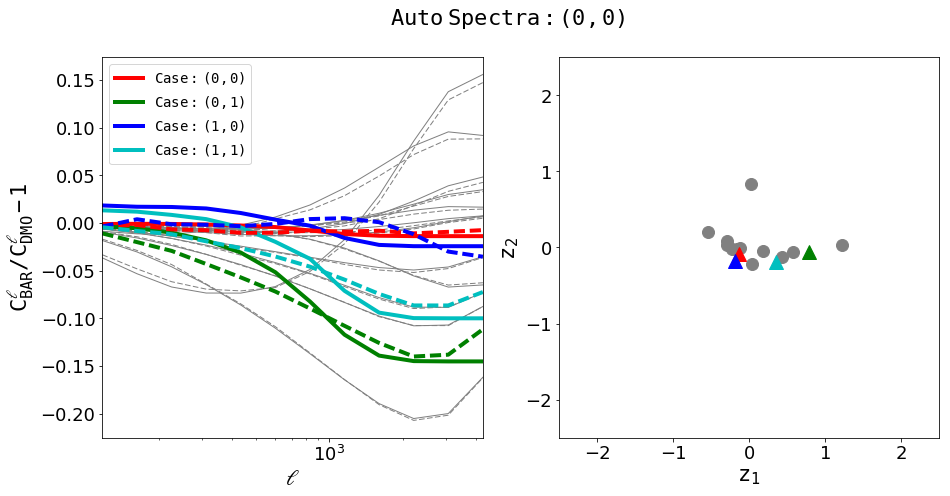

In [9]:
f, axarr = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,7))
f.subplots_adjust(hspace=0.0, wspace=0.2)

for i in range(12):
    z, delta = get_fit(np.expand_dims(x_train[i], axis=0))
    axarr[0].semilogx(ell[:12], x_train[i, :12], 'grey', lw=1)
    axarr[0].semilogx(ell[:12], delta[:12], 'grey', ls='--', lw=1)
    
    axarr[1].plot(z[0], z[1], 'grey', marker='o', ms=12)
    
axarr[0].semilogx(ell[:12], delta_00[:12], 'r', lw=4, label='$\mathtt{Case:\ (0,0)}$')    
axarr[0].semilogx(ell[:12], delta_01[:12], 'g', lw=4, label='$\mathtt{Case:\ (0,1)}$')    
axarr[0].semilogx(ell[:12], delta_10[:12], 'b', lw=4, label='$\mathtt{Case:\ (1,0)}$')    
axarr[0].semilogx(ell[:12], delta_11[:12], 'c', lw=4, label='$\mathtt{Case:\ (1,1)}$')   

axarr[0].semilogx(ell[:12], fits_delta_00[:12], '--r', lw=4)    
axarr[0].semilogx(ell[:12], fits_delta_01[:12], '--g', lw=4)    
axarr[0].semilogx(ell[:12], fits_delta_10[:12], '--b', lw=4)    
axarr[0].semilogx(ell[:12], fits_delta_11[:12], '--c', lw=4)   

axarr[1].plot(z_delta_00[0], z_delta_00[1], '^r', ms=14)
axarr[1].plot(z_delta_01[0], z_delta_01[1], '^g', ms=14)
axarr[1].plot(z_delta_10[0], z_delta_10[1], '^b', ms=14)
axarr[1].plot(z_delta_11[0], z_delta_11[1], '^c', ms=14)

axarr[0].legend(loc=2, fontsize=14)
axarr[0].set_xlim(min(ell), max(ell))   
axarr[1].set_xlim(-2.5, 2.5)   
axarr[1].set_ylim(-2.5, 2.5)   
axarr[0].set_xlabel('$\mathtt{\ell}$', fontsize=22)
axarr[0].set_ylabel('$\mathtt{C^{\ell}_{BAR}/C^{\ell}_{DMO}-1}$', fontsize=22)

axarr[1].set_xlabel('$\mathtt{z_1}$', fontsize=22)
axarr[1].set_ylabel('$\mathtt{z_2}$', fontsize=22)

f.suptitle('$\mathtt{Auto\ Spectra: (0,0)}$', fontsize=22)

plt.savefig('files/boost_vae.png', bbox_inches='tight', dpi=100) 

[-0.52440051 -0.42831603 -0.33603814 -0.2465414  -0.15898053 -0.07262408
  0.01319316  0.09910786  0.18576178  0.27383617  0.36409178  0.45742107
  0.55492294  0.65801839  0.76864301  0.88959348  1.02521202  1.18291684
  1.37729503  1.64485363]
(180, 400)


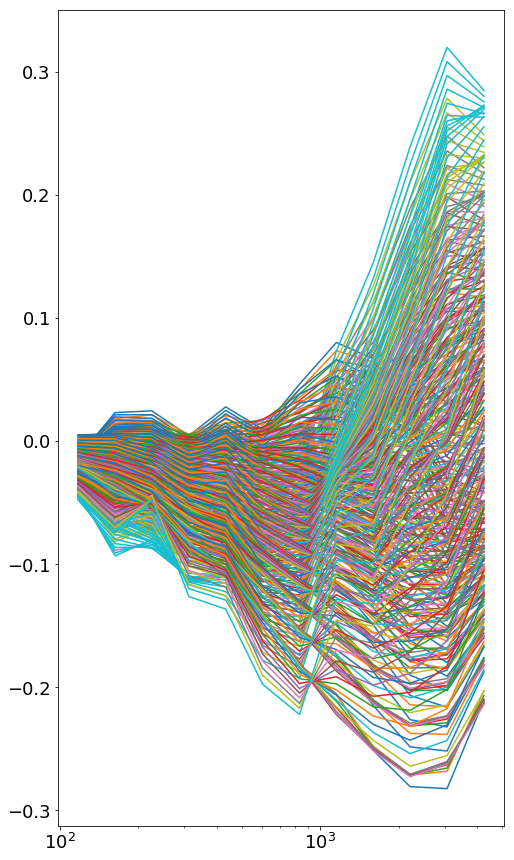

In [10]:
plt.figure(figsize=(8,15))

zarray = norm.ppf(np.linspace(0.3, 0.95, 20))
print zarray
newdata = []
for i in range(len(zarray)):
    for j in range(len(zarray)):
        z = np.array([zarray[i], zarray[j]])
        delta = get_delta(np.expand_dims(z, axis=0))
        plt.semilogx(ell[:12], delta[:12])
        newdata.append(delta)
newdata = np.transpose(np.array(newdata))
print newdata.shape

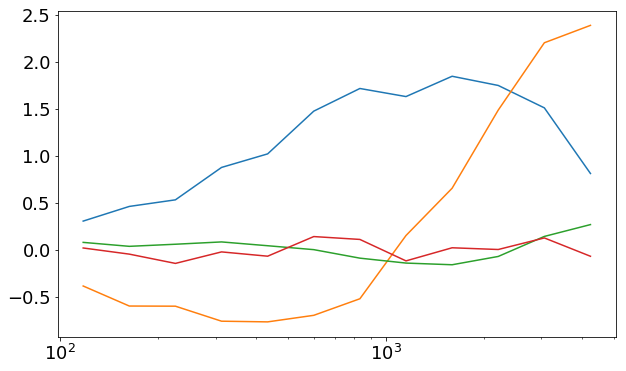

In [11]:
from ManifoldLearning import DimensionalReduction as DR
def get_pc(delta, ncomp):
    drobj = DR(delta)
    PC = drobj.TSVD(ncomp)
    return PC

plt.figure(figsize=(10,6))
newPC = get_pc(newdata, 4)
for i in range(len(newPC[0])):
    plt.semilogx(ell[:12], newPC[:12, i])


In [12]:
from scipy.optimize import curve_fit
def fittingfunc(x, a1, a2, a3, a4):
    global ell, newPC
    return a1*np.interp(x, fullell, newPC[:,0]) +\
            a2*np.interp(x, fullell, newPC[:,1]) +\
            a3*np.interp(x, fullell, newPC[:,2]) +\
            a4*np.interp(x, fullell, newPC[:,3])
            
def map_sim(ll, delta_ell):
    fit, cov = curve_fit(fittingfunc, ll, delta_ell)
    fit_delta = fittingfunc(ll, *fit)
    return fit, fit_delta

In [13]:
# fulldelta = np.load('../Baryons_EiflerData/data_Eifler/delta%s.npy'%case)
# fullell = np.load('../Baryons_EiflerData/savedfiles/ell.npy')

coeff = []
fits_delta = []
for i in range(len(FullDelta[0])):
    ff, dd = map_sim(fullell, FullDelta[:,i])
    coeff.append(ff)
    fits_delta.append(dd)
coeff = np.array(coeff)
fits_delta = np.transpose(np.array(fits_delta))
print FullDelta.shape, fits_delta.shape

fits00, fits2_delta_00 = map_sim(fullell, delta_00)
fits01, fits2_delta_01 = map_sim(fullell, delta_01)
fits10, fits2_delta_10 = map_sim(fullell, delta_10)
fits11, fits2_delta_11 = map_sim(fullell, delta_11)


(180, 12) (180, 12)


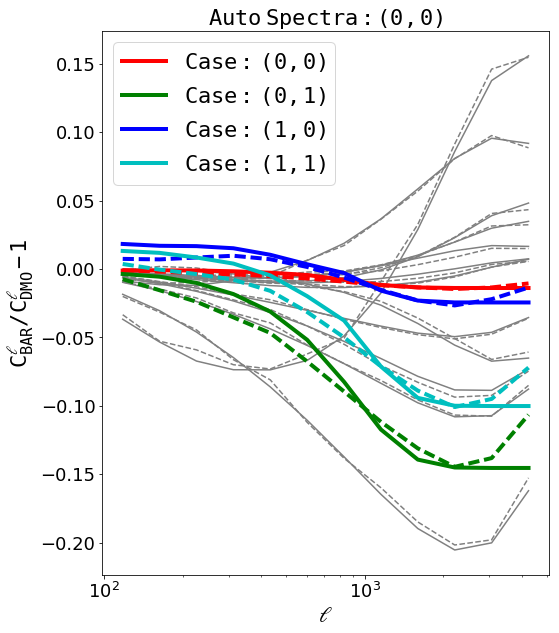

In [14]:
plt.figure(figsize=(8,10))
for i in range(12):
    plt.semilogx(fullell[:12], FullDelta[:12, i], 'grey')
    plt.semilogx(fullell[:12], fits_delta[:12, i], 'grey', ls='--')
    
plt.semilogx(fullell[:12], delta_00[:12], 'r', lw=4, label='$\mathtt{Case:\ (0,0)}$')
plt.semilogx(fullell[:12], fits2_delta_00[:12], '--r', lw=4)

plt.semilogx(fullell[:12], delta_01[:12], 'g', lw=4, label='$\mathtt{Case:\ (0,1)}$')
plt.semilogx(fullell[:12], fits2_delta_01[:12], '--g', lw=4)

plt.semilogx(fullell[:12], delta_10[:12], 'b', lw=4, label='$\mathtt{Case:\ (1,0)}$')
plt.semilogx(fullell[:12], fits2_delta_10[:12], '--b', lw=4)

plt.semilogx(fullell[:12], delta_11[:12], 'c', lw=4, label='$\mathtt{Case:\ (1,1)}$')
plt.semilogx(fullell[:12], fits2_delta_11[:12], '--c', lw=4)

plt.legend(loc=2, fontsize=22)

plt.xlabel('$\mathtt{\ell}$', fontsize=22)
plt.ylabel('$\mathtt{C^{\ell}_{BAR}/C^{\ell}_{DMO}-1}$', fontsize=22)

plt.title('$\mathtt{Auto\ Spectra: (0,0)}$', fontsize=22)

plt.savefig('files/boost_vae_pca.png', bbox_inches='tight', dpi=100) 

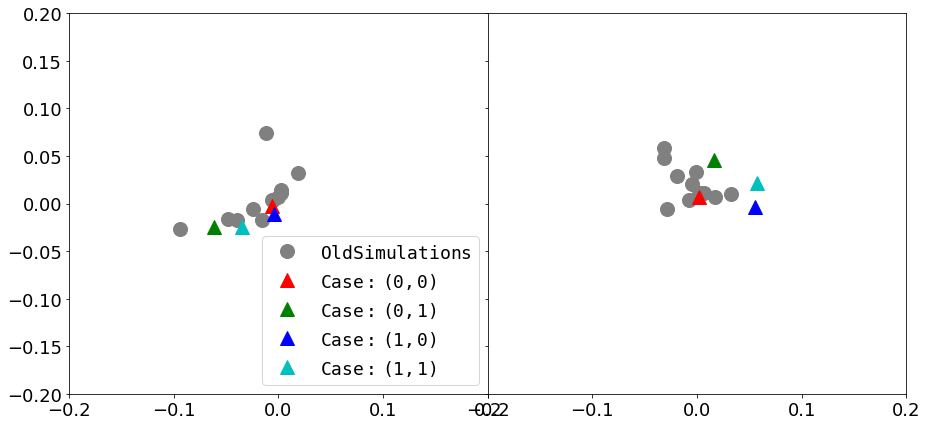

In [15]:
f, axarr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,7))
f.subplots_adjust(hspace=0.0, wspace=0.00)

axarr[0].plot(coeff[:,0], coeff[:,1], 'grey', marker='o', ls='', ms=14, label='$\mathtt{OldSimulations}$')
axarr[1].plot(coeff[:,2], coeff[:,3], 'grey', marker='o', ls='', ms=14)

axarr[0].plot(fits00[0], fits00[1], '^r', ms=14, label='$\mathtt{Case:\ (0,0)}$')
axarr[1].plot(fits00[2], fits00[3], '^r', ms=14)

axarr[0].plot(fits01[0], fits01[1], '^g', ms=14, label='$\mathtt{Case:\ (0,1)}$')
axarr[1].plot(fits01[2], fits01[3], '^g', ms=14)

axarr[0].plot(fits10[0], fits10[1], '^b', ms=14, label='$\mathtt{Case:\ (1,0)}$')
axarr[1].plot(fits10[2], fits10[3], '^b', ms=14)

axarr[0].plot(fits11[0], fits11[1], '^c', ms=14, label='$\mathtt{Case:\ (1,1)}$')
axarr[1].plot(fits11[2], fits11[3], '^c', ms=14)

# axarr[0].text(-4,4, '$\mathtt{(a_1, a_2)\ plane}$', fontsize=22)
# axarr[1].text(-4,4, '$\mathtt{(a_3, a_4)\ plane}$', fontsize=22)

axarr[0].legend(loc=4, fontsize=18)
axarr[0].set_xlim(-.2,.2)
axarr[0].set_ylim(-.2,.2)

f.savefig('coeff_vae_pca.png', bbox_inches='tight', dpi=100) 